# Conditional Generative Adversarial Nets

TensorFlow implementation of [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784). The concept is from the paper but this notebook implements a different architecture which is using Convolutional and de-Convolutional Neural Networks.

For the implementation most similar to what's described in the paper, see this notebook.

For the impatints, here is what we're heading toward for.

Now, let's get started.

In [1]:
import tensorflow as tf

# Hyper-parameters

In [2]:
# for input
batch_size = 100
h_size, w_size, c_size = 28, 28, 1
y_size = 10
z_size = 100
half_size, quarter_size = h_size//2, h_size//4

# for discriminator
D_conv1_filter_size = 5
D_conv1_channel_size = 10
D_conv2_filter_size = 5
D_conv2_channel_size = 64
D_fc1_incoming_size = D_conv2_channel_size * quarter_size * quarter_size
D_fc1_size = 1024
D_output_size = 1

# for generator
G_deconv1_filter_size = 5
G_deconv1_channel_size = 128
G_deconv2_filter_size = 5
G_deconv2_channel_size = 128
G_fc1_size = 1024
G_fc2_size = G_deconv1_channel_size * quarter_size * quarter_size

# Variables

In [3]:
def make_variable(shape):
    return tf.Variable(tf.random_normal(shape=shape, stddev=0.02))

In [4]:
D_weights = {
    'conv1' : make_variable((D_conv1_filter_size, D_conv1_filter_size, c_size + y_size, D_conv1_channel_size)),
    'conv2' : make_variable((D_conv2_filter_size, D_conv2_filter_size, D_conv1_channel_size, D_conv2_channel_size)),
    'fc1' : make_variable((D_fc1_incoming_size, D_fc1_size)),
    'output' : make_variable((D_fc1_size, D_output_size)),
    
    'conv1_bias' : tf.Variable(tf.zeros(shape=(D_conv1_channel_size))),
    'conv2_bias' : tf.Variable(tf.zeros(shape=(D_conv2_channel_size))),
    'fc1_bias' : tf.Variable(tf.zeros(shape=(D_fc1_size))),
    'output_bias' : tf.Variable(tf.zeros(shape=(D_output_size))),
}

G_weights = {
    'fc1' : make_variable((z_size + y_size, G_fc1_size)),
    'fc2' : make_variable((G_fc1_size, G_fc2_size)),
    'deconv1' : make_variable((G_deconv1_filter_size, G_deconv1_filter_size, G_deconv2_channel_size, G_deconv1_channel_size)),
    'deconv2' : make_variable((G_deconv2_filter_size, G_deconv2_filter_size, c_size, G_deconv2_channel_size)),
    
    'fc1_bias' : tf.Variable(tf.zeros(shape=(G_fc1_size))),
    'fc2_bias' : tf.Variable(tf.zeros(shape=(G_fc2_size))),
    'deconv1_bias' : tf.Variable(tf.zeros(shape=(G_deconv2_channel_size))),
    'deconv2_bias' : tf.Variable(tf.zeros(shape=(c_size))),
}

In [5]:
x = tf.placeholder(tf.float32, shape=(None, h_size, w_size, c_size))
y = tf.placeholder(tf.float32, shape=(None, y_size))
z = tf.placeholder(tf.float32, shape=(None, z_size))

In [6]:
# for batch normalization
is_training = tf.placeholder(tf.bool, [])

# Model

In [7]:
def batch_norm(X, scope='scope', reuse=False):
    return tf.contrib.layers.batch_norm(X, decay=0.9, scale=True, updates_collections=None, is_training=is_training,
                                        reuse=reuse, scope=scope)

def fully_connected(X, W, b):
    return tf.matmul(X, W) + b

def convolution(X, W, b):
    conv = tf.nn.conv2d(X, W, strides=[1, 2, 2, 1], padding='SAME')
    conv = tf.nn.bias_add(conv, b)
    return conv

def deconvolution(X, W, b, output_shape):
    deconv = tf.nn.conv2d_transpose(X, W, output_shape=output_shape, strides=[1,2,2,1], padding='SAME')
    deconv = tf.nn.bias_add(deconv, b)
    return deconv

In [8]:
def D(x, y, w=D_weights, reuse=False):
    # x shape : (batch_size, 28, 28, 1)
    # y shape : (batch_size, 10)
    
    y_reshaped = tf.reshape(y, shape=(batch_size, 1, 1, y_size)) * tf.ones_like(x)
    xy = tf.concat(3, [x, y_reshaped])
    
    conv1 = convolution(xy, w['conv1'], w['conv1_bias'])
    conv1 = tf.nn.relu(conv1)
    
    conv2 = convolution(conv1, w['conv2'], w['conv2_bias'])
    conv2 = batch_norm(conv2, scope='D_conv2_bn', reuse=reuse)
    conv2 = tf.nn.relu(conv2)
    
    conv_flattened = tf.reshape(conv2, shape=(batch_size, -1))
    
    fc1 = fully_connected(conv_flattened, w['fc1'], w['fc1_bias'])
    fc1 = batch_norm(fc1, scope='D_fc1_bn', reuse=reuse)
    fc1 = tf.nn.relu(fc1)
    
    fc2 = fully_connected(fc1, w['output'], w['output_bias'])
    
    return tf.nn.sigmoid(fc2)

In [9]:
def G(z, y, w=G_weights, reuse=False):
    # z shape : (batch_size, 100)
    # y shape : (batch_size, 10)
    
    zy = tf.concat(1, [z, y])
    fc1 = fully_connected(zy, w['fc1'], w['fc1_bias'])
    fc1 = batch_norm(fc1, scope='G_fc1_bn', reuse=reuse)
    fc1 = tf.nn.relu(fc1)
    
    fc2 = fully_connected(fc1, w['fc2'], w['fc2_bias'])
    fc2 = batch_norm(fc2, scope='G_fc2_bn', reuse=reuse)
    fc2 = tf.nn.relu(fc2)
    
    fc_reshaped = tf.reshape(fc2, shape=(batch_size, 7, 7, 128))
    
    deconv1 = deconvolution(fc_reshaped, w['deconv1'], w['deconv1_bias'], 
                            output_shape=(batch_size, h_size//2, w_size//2, 128))
    deconv1 = batch_norm(deconv1, scope='G_deconv1_bn', reuse=reuse)
    deconv1 = tf.nn.relu(deconv1)
    
    deconv2 = deconvolution(deconv1, w['deconv2'], w['deconv2_bias'], 
                           output_shape=(batch_size, h_size, w_size, 1))
    return tf.nn.sigmoid(deconv2)

In [10]:
D_prob_real_x = D(x, y)
fake_x = G(z, y)
D_prob_fake_x = D(fake_x, y, reuse=True)

In [11]:
fake_images = G(z, y, reuse=True) # for sampling

# Objective

In [12]:
D_objective = -tf.reduce_mean(tf.log(D_prob_real_x) + tf.log(1 - D_prob_fake_x))
G_objective = -tf.reduce_mean(tf.log(D_prob_fake_x))

# Optimizer

In [13]:
D_optimizer = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5).minimize(D_objective, var_list=D_weights.values())
G_optimizer = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5).minimize(G_objective, var_list=G_weights.values())

# Training

In [14]:
from tensorflow.examples.tutorials.mnist.input_data import read_data_sets

In [15]:
mnist = read_data_sets('/tmp/data/', one_hot=True, reshape=False)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [16]:
session = tf.InteractiveSession()

In [17]:
tf.global_variables_initializer().run()
iteration = 0

In [18]:
from module.helper import generate_z, generate_y

In [19]:
sampled_z = generate_z(batch_size, z_size)
sampled_y = generate_y(batch_size)

In [ ]:
# for tracking
samples = []
p_real_list = []
p_fake_list = []

In [ ]:
for _ in range(500):
    train_x, train_y = mnist.train.next_batch(batch_size)
    generated_z = generate_z(batch_size, z_size)
    
    D_optimizer.run(feed_dict={x:train_x, y:train_y, z:generated_z, is_training:True})
    G_optimizer.run(feed_dict={y:train_y, z:generated_z, is_training:True})
    
    p_real = D_prob_real_x.eval(feed_dict={x:train_x, y:train_y, z:generated_z, is_training:False}).mean()
    p_fake = D_prob_fake_x.eval(feed_dict={x:train_x, y:train_y, z:generated_z, is_training:False}).mean()
    p_real_list.append(p_real)
    p_fake_list.append(p_fake)
    
    if iteration % 50 == 0:
        print("iteration {i:<4d}  D objective: {D_obj:<.6f}  G objective: {G_obj:<.6f}  D(x,y): {p_real:<.6f}  D(G(z,y),y): {p_fake:<.6f}".format(
            i=iteration,
            D_obj=D_objective.eval(feed_dict={x:train_x, y:train_y, z:generated_z, is_training:False}),
            G_obj=G_objective.eval(feed_dict={y:train_y, z:generated_z, is_training:False}),
            p_real=p_real,
            p_fake=p_fake))

        samples.append(fake_images.eval(feed_dict={z:sampled_z, y:sampled_y, is_training:False})[:10])
        
    iteration += 1

iteration 0     D objective: 1.388632  G objective: 0.696893  D(x,y): 0.497024  D(G(z,y),y): 0.498148
iteration 50    D objective: 1.108653  G objective: 0.944887  D(x,y): 0.566899  D(G(z,y),y): 0.398506
iteration 100   D objective: 1.271637  G objective: 0.982347  D(x,y): 0.526875  D(G(z,y),y): 0.406536
iteration 150   D objective: 1.111911  G objective: 0.876768  D(x,y): 0.587169  D(G(z,y),y): 0.424454
iteration 200   D objective: 1.180682  G objective: 0.862801  D(x,y): 0.565632  D(G(z,y),y): 0.435125
iteration 250   D objective: 1.161436  G objective: 0.775528  D(x,y): 0.597271  D(G(z,y),y): 0.465715
iteration 300   D objective: 1.186013  G objective: 0.889761  D(x,y): 0.546831  D(G(z,y),y): 0.421938
iteration 350   D objective: 1.186207  G objective: 0.783813  D(x,y): 0.592020  D(G(z,y),y): 0.466825
iteration 400   D objective: 1.135654  G objective: 0.779518  D(x,y): 0.608476  D(G(z,y),y): 0.463786
iteration 450   D objective: 1.208030  G objective: 0.797413  D(x,y): 0.567922  D(

# Training Visualization

In [1]:
%matplotlib inline
from module.helper import interactive_plot, square_plot

In [53]:
interactive_plot(p_real_list, p_fake_list, data1_name='D(x,y)', data2_name='D(G(z,y),y)')

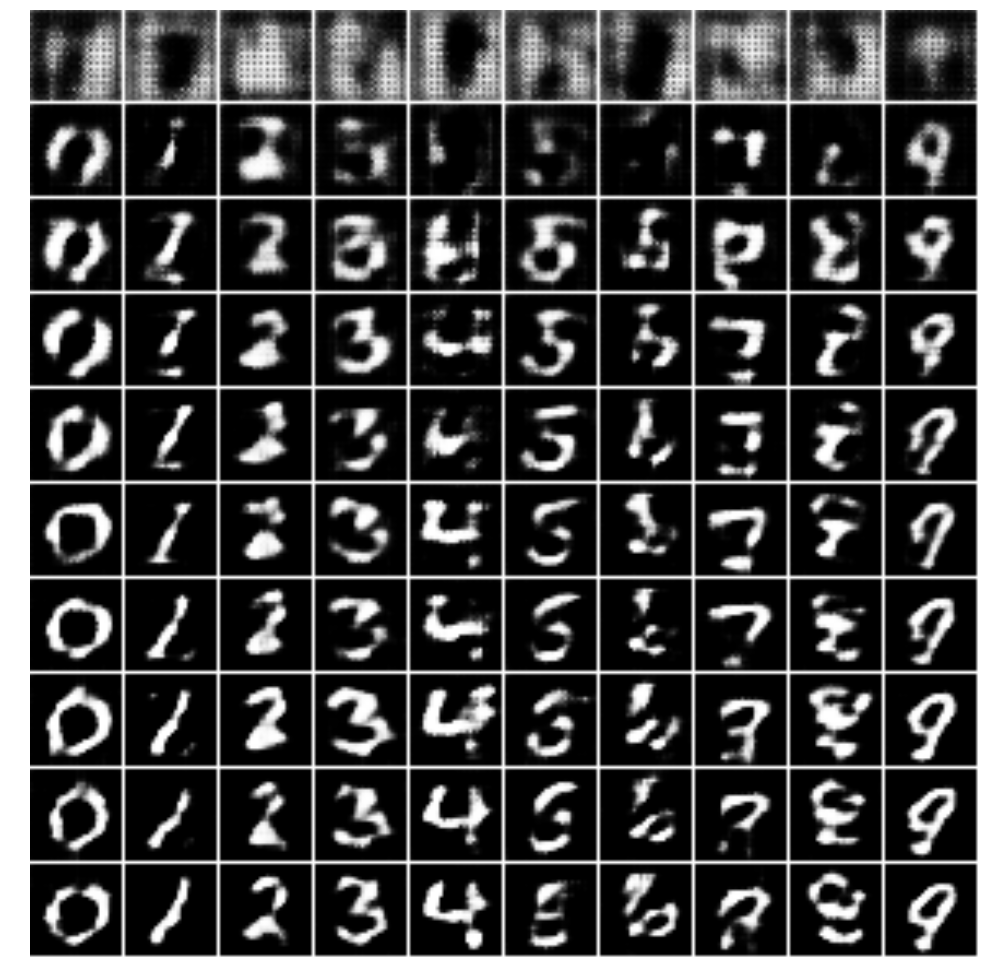

In [54]:
square_plot(samples)

# Result

In [57]:
generated_z = generate_z(batch_size, z_size)
generated_y = generate_y(batch_size)
generated_images = fake_images.eval(feed_dict={z:generated_z, y:generated_y, is_training:False})

In [58]:
square_plot(generated_images)

IndexError: too many indices for array